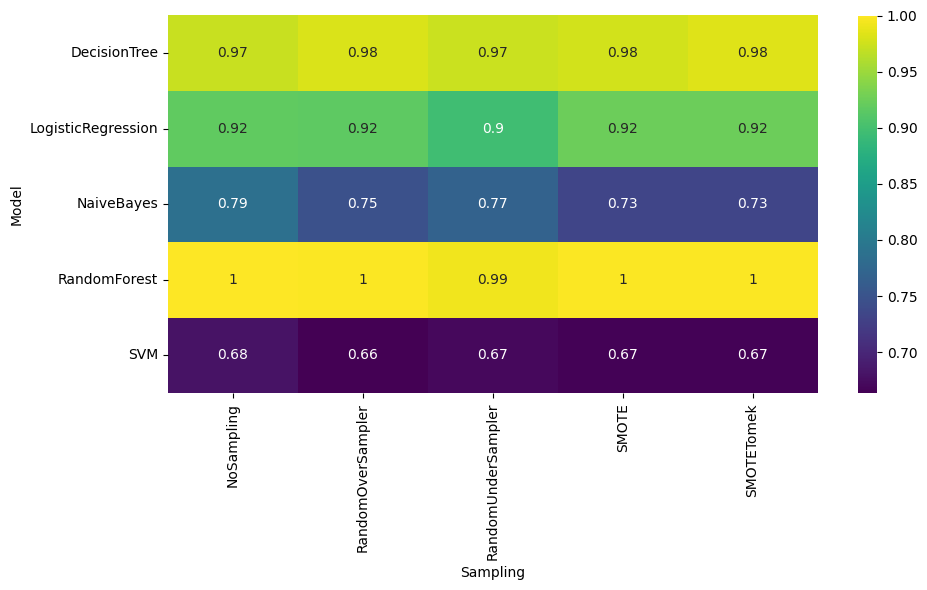

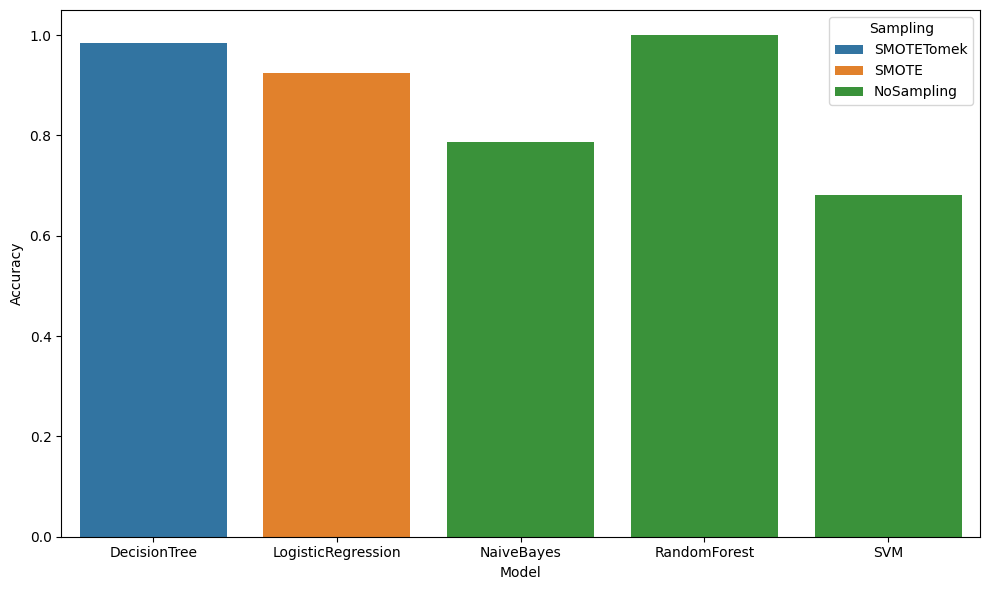

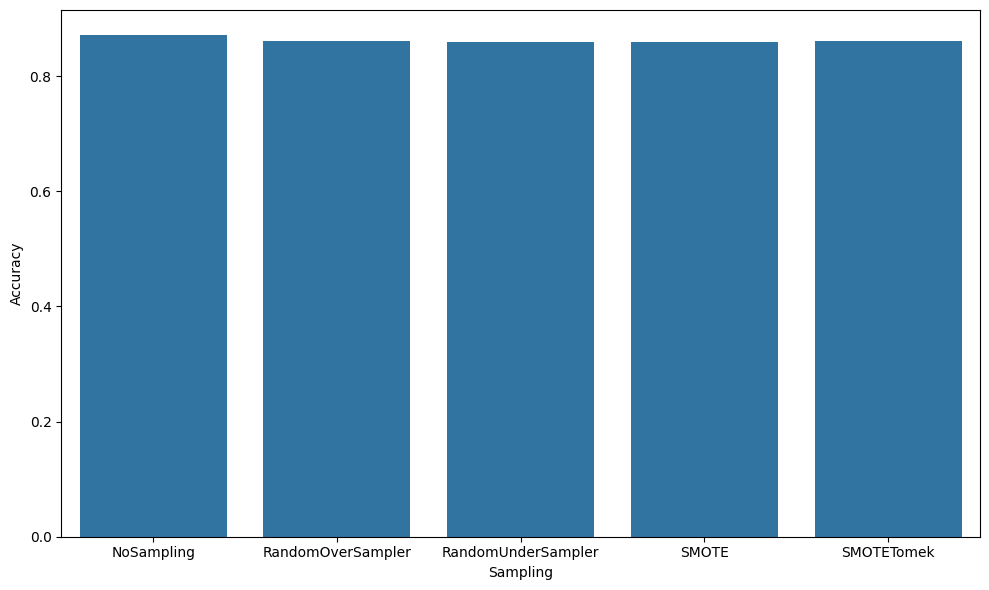

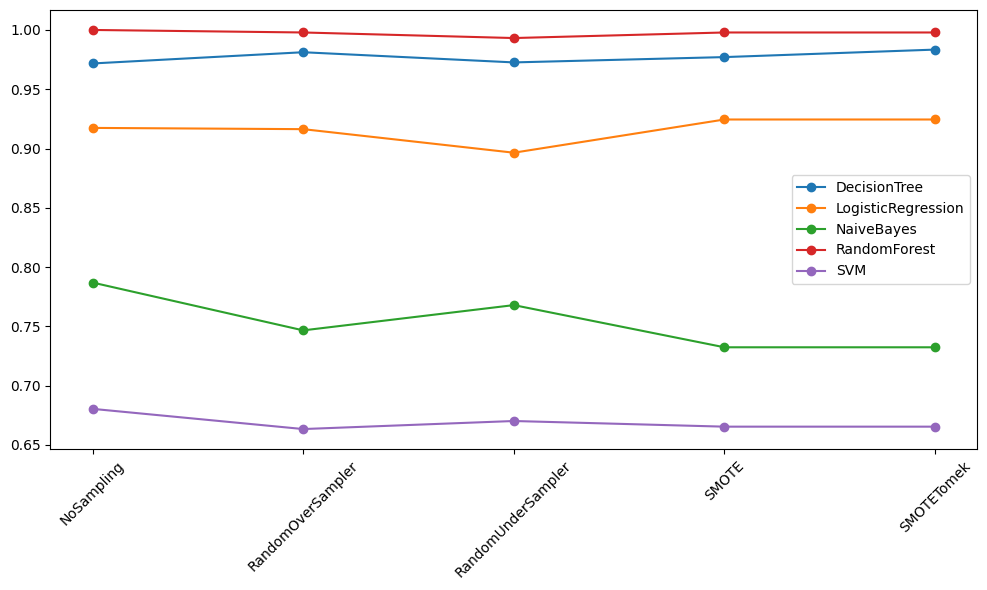

                 Model            Sampling  Accuracy
0   LogisticRegression   RandomOverSampler  0.916337
1   LogisticRegression  RandomUnderSampler  0.896475
2   LogisticRegression               SMOTE  0.924480
3   LogisticRegression          SMOTETomek  0.924480
4   LogisticRegression          NoSampling  0.917391
5         DecisionTree   RandomOverSampler  0.981217
6         DecisionTree  RandomUnderSampler  0.972628
7         DecisionTree               SMOTE  0.977115
8         DecisionTree          SMOTETomek  0.983435
9         DecisionTree          NoSampling  0.971739
10        RandomForest   RandomOverSampler  0.997872
11        RandomForest  RandomUnderSampler  0.993180
12        RandomForest               SMOTE  0.997872
13        RandomForest          SMOTETomek  0.997872
14        RandomForest          NoSampling  1.000000
15          NaiveBayes   RandomOverSampler  0.746628
16          NaiveBayes  RandomUnderSampler  0.767937
17          NaiveBayes               SMOTE  0.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

df = pd.read_csv("Creditcard_data.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

ros = RandomOverSampler(random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

samples = []
for i in range(1, 6):
    Xs = X_bal.sample(frac=0.2, random_state=i)
    ys = y_bal.loc[Xs.index]
    samples.append((Xs, ys))

sampling_methods = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "NoSampling": None
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC()
}

records = []

for model_name, model in models.items():
    for sampling_name, sampler in sampling_methods.items():
        acc_list = []
        for Xs, ys in samples:
            if sampler is not None:
                X_res, y_res = sampler.fit_resample(Xs, ys)
            else:
                X_res, y_res = Xs, ys
            X_train, X_test, y_train, y_test = train_test_split(
                X_res, y_res, test_size=0.3, random_state=42
            )
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc_list.append(accuracy_score(y_test, preds))
        records.append([model_name, sampling_name, np.mean(acc_list)])

result_df = pd.DataFrame(records, columns=["Model", "Sampling", "Accuracy"])
result_df.to_csv("accuracy_matrix.csv", index=False)

pivot_df = result_df.pivot(index="Model", columns="Sampling", values="Accuracy")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_df, annot=True, cmap="viridis")
plt.tight_layout()
plt.savefig("accuracy_heatmap.png")
plt.show()
plt.close()

best_sampling = result_df.loc[result_df.groupby("Model")["Accuracy"].idxmax()]
best_sampling.to_csv("best_sampling_per_model.csv", index=False)

plt.figure(figsize=(10,6))
sns.barplot(data=best_sampling, x="Model", y="Accuracy", hue="Sampling")
plt.tight_layout()
plt.savefig("best_accuracy_per_model.png")
plt.show()
plt.close()

avg_sampling = result_df.groupby("Sampling")["Accuracy"].mean().reset_index()
avg_sampling.to_csv("avg_accuracy_per_sampling.csv", index=False)

plt.figure(figsize=(10,6))
sns.barplot(data=avg_sampling, x="Sampling", y="Accuracy")
plt.tight_layout()
plt.savefig("avg_accuracy_per_sampling.png")
plt.show()
plt.close()

plt.figure(figsize=(10,6))
for model in pivot_df.index:
    plt.plot(pivot_df.columns, pivot_df.loc[model], marker="o", label=model)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("accuracy_lineplot_all_combinations.png")
plt.show()
plt.close()

print(result_df)
